Start

In [1]:
# imports
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

pd.options.display.max_columns=None
pd.options.display.max_rows=None
pd.options.display.max_colwidth=None

In [2]:
RAW_PATH = config['Paths']['raw_data']
df_raw = pd.read_csv(f'{RAW_PATH}heart.csv', delimiter=",")
print(df_raw.info())

df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
# list of numerical & categorical features
df = df_raw.copy()

col = list(df.columns)

numerical_feats = []
categorical_feats = []

for i in col:
    if pd.api.types.is_numeric_dtype(df[i]):
        numerical_feats.append(i)
    elif pd.api.types.is_categorical_dtype(df[i]) or pd.api.types.is_object_dtype(df[i]):
        categorical_feats.append(i)

print(f'Numerical Features: {numerical_feats}')
print(f'Categorical Features: {categorical_feats}')

Numerical Features: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']
Categorical Features: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [4]:
# add 'Cholesterol_imp' into numerical_feats before 'HeartDisease'
numerical_feats.insert(-1, 'Cholesterol_imp')
numerical_feats

['Age',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'Oldpeak',
 'Cholesterol_imp',
 'HeartDisease']

In [5]:
PP_PATH = config['Paths']['processed_data']
df_pp = pd.read_csv(f'{PP_PATH}heart_encoded_2.csv', delimiter=",")
print(df_pp.info())

df_pp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              918 non-null    int64  
 1   Sex              918 non-null    int64  
 2   ChestPainType    918 non-null    int64  
 3   RestingBP        918 non-null    int64  
 4   Cholesterol      918 non-null    int64  
 5   FastingBS        918 non-null    int64  
 6   RestingECG       918 non-null    int64  
 7   MaxHR            918 non-null    int64  
 8   ExerciseAngina   918 non-null    int64  
 9   Oldpeak          918 non-null    float64
 10  ST_Slope         918 non-null    int64  
 11  HeartDisease     918 non-null    int64  
 12  Cholesterol_imp  918 non-null    int64  
dtypes: float64(1), int64(12)
memory usage: 93.4 KB
None


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Cholesterol_imp
0,40,1,1,140,289,0,1,172,0,0.0,2,0,289
1,49,0,2,160,180,0,1,156,0,1.0,1,1,180
2,37,1,1,130,283,0,2,98,0,0.0,2,0,283
3,48,0,0,138,214,0,1,108,1,1.5,1,1,214
4,54,1,2,150,195,0,1,122,0,0.0,2,0,195


Note: 
1. Normalization
- done for features which does not display normal distribution
- Columns: 'Oldpeak'

2. Standardization
- done for features which are normally distributed but values have high fluctuation (too big or too small)
- Columns: 'Age', 'RestingBP', 'Cholesterol', 'MaxHR'

In [6]:
# data scaling for existing numerical categories
# simple helper func
def normalize_data(df, column_name,):
    MMS = MinMaxScaler()
    df[column_name] = MMS.fit_transform(df[[column_name]])

    return df

def standardize_date(df, column_name, ):
    SS = StandardScaler()
    df[column_name] = SS.fit_transform(df[[column_name]])

    return df

In [7]:
column_to_norm_scale_list = ['Oldpeak']
column_to_std_scale_list = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Cholesterol_imp']

df_pp_01 = df_pp.copy()

for i in column_to_norm_scale_list:
    normalize_data(df_pp_01, str(i))

for i in column_to_std_scale_list:
    standardize_date(df_pp_01, str(i))

df_pp_01.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Cholesterol_imp
0,-1.433140,1,1,0.410909,0.825070,-0.551341,1,1.382928,0,0.295455,2,0,0.897407
1,-0.478484,0,2,1.491752,-0.171961,-0.551341,1,0.754157,0,0.409091,1,1,-1.122849
2,-1.751359,1,1,-0.129513,0.770188,-0.551341,2,-1.525138,0,0.295455,2,0,0.786200
3,-0.584556,0,0,0.302825,0.139040,-0.551341,1,-1.132156,1,0.465909,1,1,-0.492677
4,0.051881,1,2,0.951331,-0.034755,-0.551341,1,-0.581981,0,0.295455,2,0,-0.844832


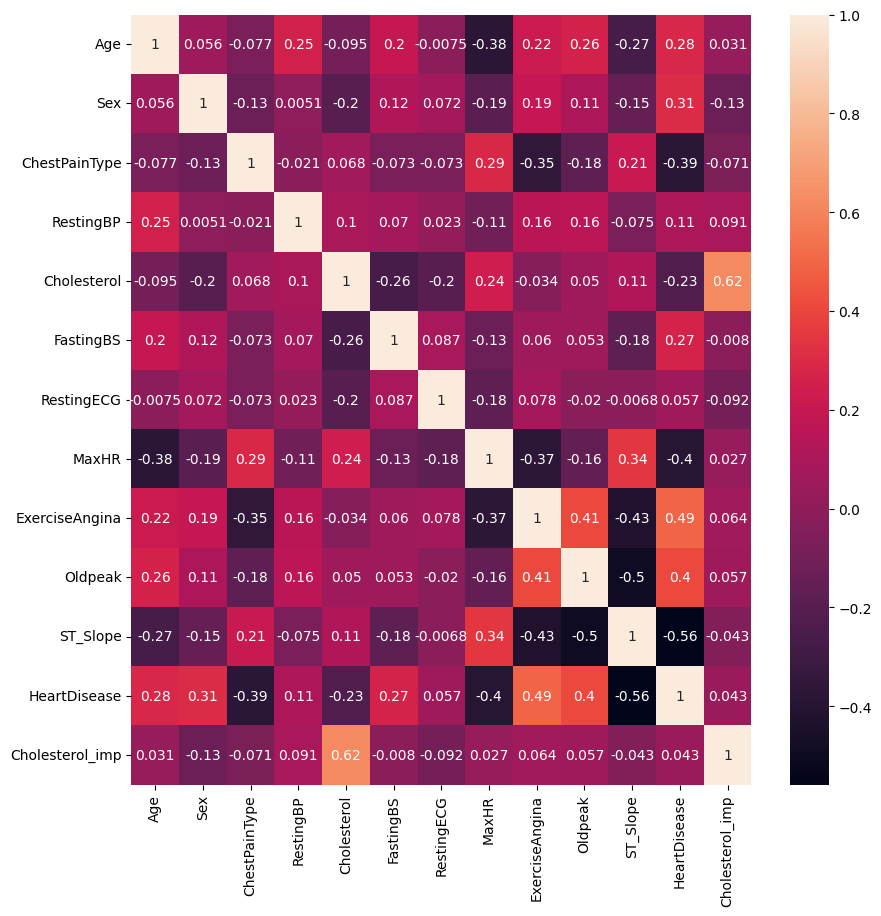

In [8]:
# plot corr for all the features
corr_df = df_pp_01.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr_df, annot=True)
plt.show()

cor_target = abs(corr_df["HeartDisease"])

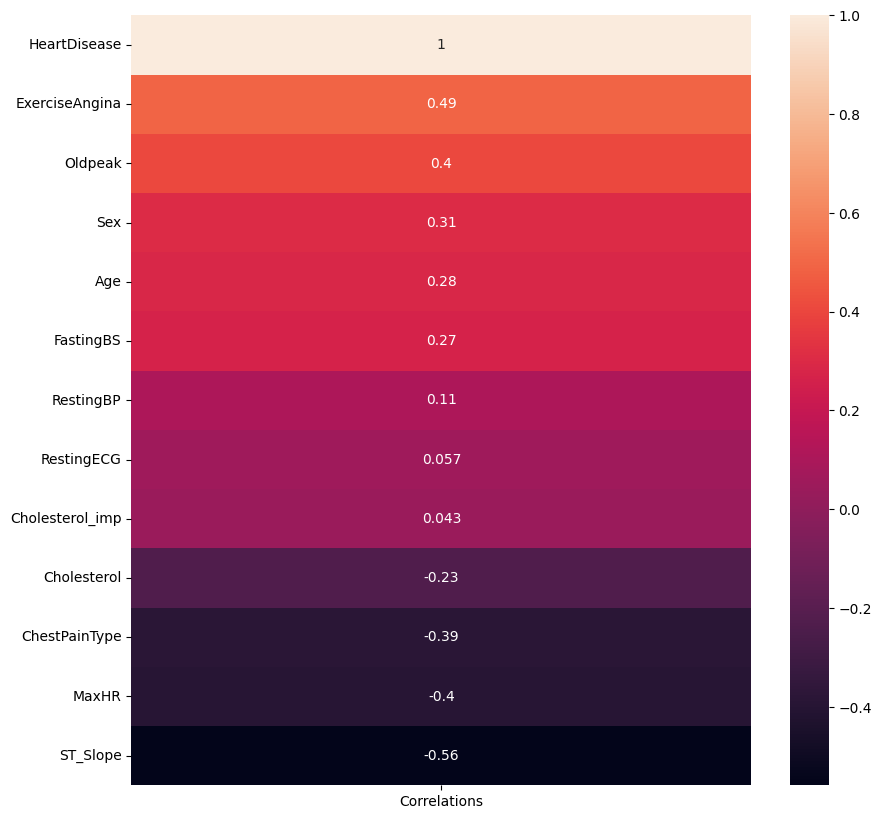

In [9]:
corr_df2 = df_pp_01.corrwith(df_pp_01['HeartDisease']).sort_values(ascending = False).to_frame()
corr_df2.columns = ['Correlations']

plt.figure(figsize=(10,10))
sns.heatmap(corr_df2, annot = True)
plt.show()

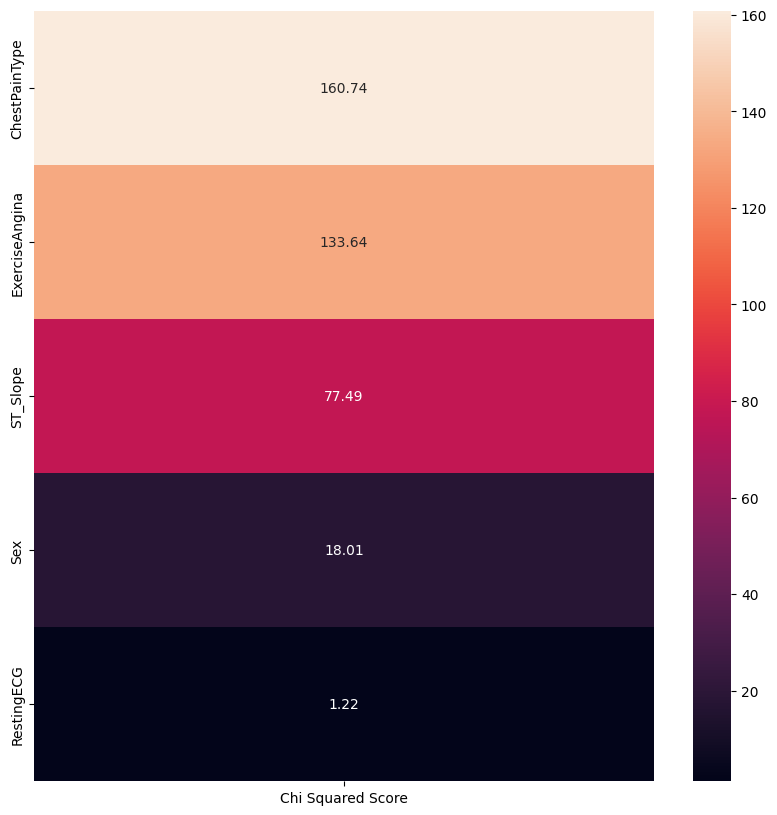

In [10]:
# feature selection for categorical features
# using selectkbest & chi2

feats = df_pp_01[categorical_feats]
target = df_pp_01[numerical_feats[-1]]

chi2_selector = SelectKBest(score_func = chi2, k = 'all') # selecting all features
chi2_selected = chi2_selector.fit_transform(feats, target)

feats_scores = pd.DataFrame(data = chi2_selector.scores_, index = list(feats.columns), columns = ['Chi Squared Score'])

plt.figure(figsize=(10,10))
sns.heatmap(feats_scores.sort_values(ascending = False, by = 'Chi Squared Score'), annot = True, fmt = '.2f')
plt.show()

In [11]:
# using statistical significance to determine significant categorical features

p_values_chi2 = chi2_selector.pvalues_
significance_level = 0.05 # default
significant_features_chi2 = feats.columns[p_values_chi2 < significance_level]

print(f'\nSignificant categorical features: {significant_features_chi2.values}')


Significant categorical features: ['Sex' 'ChestPainType' 'ExerciseAngina' 'ST_Slope']


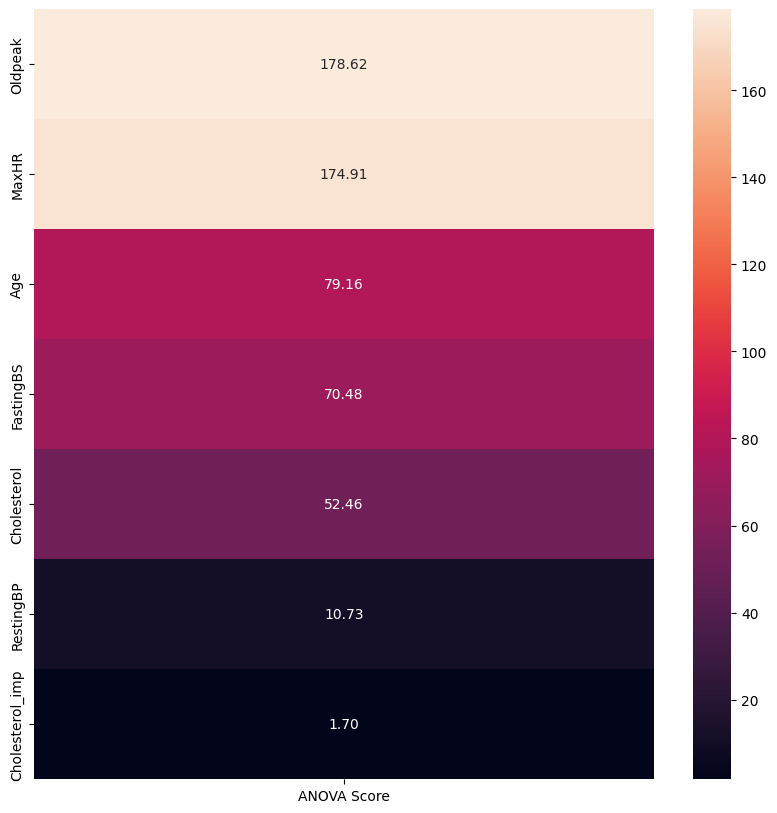

In [12]:
# feature selection for numerical features
# using selectkbest & anova

feats = df_pp_01[numerical_feats[:-1]]
target = df_pp_01[numerical_feats[-1]]

anova_selector = SelectKBest(score_func = f_classif, k = 'all') # selecting all features
anova_selected = anova_selector.fit_transform(feats, target)

feats_scores = pd.DataFrame(data = anova_selector.scores_, index = list(feats.columns), columns = ['ANOVA Score'])

plt.figure(figsize=(10,10))
sns.heatmap(feats_scores.sort_values(ascending = False, by = 'ANOVA Score'), annot = True, fmt = '.2f')
plt.show()

In [13]:
# using statistical significance to determine significant numerical features

p_values_anova = anova_selector.pvalues_
significant_features_anova = feats.columns[p_values_anova < significance_level]

print(f'\nSignificant numerical features: {significant_features_anova.values}')


Significant numerical features: ['Age' 'RestingBP' 'Cholesterol' 'FastingBS' 'MaxHR' 'Oldpeak']


All features are considerd for modeling except for: 'Cholesterol_imp' & 'RestingECG'

End